In [32]:
import numpy as np
import pandas as pd

np.random.seed(1984)

import os
import glob
import cv2
import datetime
import pandas as pd
import time
import ujson as json
import PIL
from PIL import Image
#import warnings
#warnings.filterwarnings("ignore")

from sklearn.cross_validation import KFold
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.constraints import maxnorm
from sklearn.metrics import log_loss
from keras import __version__ as keras_version
from matplotlib import pyplot as plt

%matplotlib inline

pathProj = 'J:/work/kaggle/201701_NCFM/'

In [2]:
imgX = 32
imgY = 32

In [3]:
def get_im_cv2(path, grey=False):
    img = cv2.imread(path)
    orig_size = img.shape
    resized = cv2.resize(img, (imgX, imgY), cv2.INTER_LINEAR)
    if grey:
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return resized, orig_size

def load_train(grey=False):
    X_train = []
    X_train_id = []
    y_train = []
    orig_sizes = []
    start_time = time.time()

    print('Read train images')
    folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    for fld in folders:
        index = folders.index(fld)
        print('Load folder {} (Index: {})'.format(fld, index))
        path = os.path.join(pathProj, 'train', fld, '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img, orig_size = get_im_cv2(fl, grey)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)
            orig_sizes.append(orig_size)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id, orig_sizes


def load_test():
    path = os.path.join(pathProj, 'test_stg1', '*.jpg')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    for fl in files:
        flbase = os.path.basename(fl)
        img, orig_size = get_im_cv2(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)


def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
    result1.loc[:, 'image'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    result1.to_csv(sub_file, index=False)

In [4]:
def read_and_normalize_train_data(grey=False):
    train_data, train_target, train_id, orig_sizes = load_train(grey)

    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    if(grey):
        train_data = train_data.reshape((train_data.shape[0],1, train_data.shape[1], train_data.shape[2]))
    else:
        print('Reshape...')
        train_data = train_data.transpose((0, 3, 1, 2))

    print('Convert to float...')
    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = np_utils.to_categorical(train_target, 8)

    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, train_id, orig_sizes


def read_and_normalize_test_data():
    start_time = time.time()
    test_data, test_id = load_test()

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 3, 1, 2))

    test_data = test_data.astype('float32')
    test_data = test_data / 255

    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id

In [5]:
X_train, y_train, X_train_id, orig_sizes = read_and_normalize_train_data(grey=True)

Read train images
Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder NoF (Index: 4)
Load folder OTHER (Index: 5)
Load folder SHARK (Index: 6)
Load folder YFT (Index: 7)
Read train data time: 115.28 seconds
Convert to numpy...
Convert to float...
Train shape: (3777, 1, 32, 32)
3777 train samples


In [ ]:
X_train, y_train, X_train_id, orig_sizes = read_and_normalize_train_data()

In [7]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

bb_json = {}
for c in anno_classes:
    j = json.load(open('{}/annos/{}_labels.json'.format(pathProj, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [8]:
for f in X_train_id:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [9]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (imgX / size[1])
    conv_y = (imgY / size[0])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [10]:
bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(X_train_id, orig_sizes)], 
                   ).astype(np.float32)

In [11]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i, grey=False):
    bb = bbox[i]
    if (not grey):
        plt.imshow(X_train[i].transpose((1,2,0)))
    else:
        plt.imshow(X_train[i][0])
    plt.gca().add_patch(create_rect(bb))

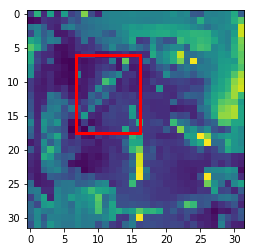

In [12]:
show_bb(0, grey = True)

In [35]:
from utils import load_array, save_array, get_classes, split_at, to_categorical

In [14]:
from vgg16bn import Vgg16BN
from utils import vgg_ft_bn
model = vgg_ft_bn(8)

In [15]:
trn = load_array(pathProj+'results/trn.dat')
val = load_array(pathProj+'results/val.dat')

In [16]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(pathProj)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 0 images belonging to 0 classes.


In [41]:
raw_filenames = [os.path.basename(f) for f in filenames]
raw_test_filenames = [os.path.basename(f) for f in test_filenames]
raw_val_filenames = [os.path.basename(f) for f in val_filenames]

In [17]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(trn, trn_labels, batch_size=8, nb_epoch=4, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 1150s - loss: 2.1910 - acc: 0.6741 - val_loss: 1.2839 - val_acc: 0.8540

In [11]:
model.save_weights(pathProj+'results/ft1_v2.h5')

In [18]:
model.load_weights(pathProj+'results/ft1_v2.h5')

In [19]:
conv_layers,fc_layers = split_at(model, Convolution2D)
conv_model = Sequential(conv_layers)

In [20]:
conv_feat = conv_model.predict(trn, batch_size=8, verbose=1)

3277/3277 [==============================] - 1179s     

In [26]:
conv_val_feat = conv_model.predict(val, batch_size=8, verbose=1)

500/500 [==============================] - 122s     

In [28]:
save_array(pathProj+'results/conv_feat.dat', conv_feat)
save_array(pathProj+'results/conv_val_feat.dat', conv_val_feat)

In [ ]:
conv_feat = load_array(pathProj+'results/conv_feat.dat')
conv_val_feat = load_array(pathProj+'results/conv_val_feat.dat')

In [37]:
sizes = [PIL.Image.open(pathProj+'train_split/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
raw_val_sizes = [PIL.Image.open(pathProj+'valid_split/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [38]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

KeyError: 'ALB\\img_00003.jpg'

In [23]:
p=0.6
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)

In [24]:
model_bb = Model([inp], [x_bb])
model_bb.compile(Adam(lr=0.001), loss=['mse'], metrics=['accuracy'])

In [25]:
model_bb.fit(conv_feat, bbox, batch_size=8, nb_epoch=3, validation_split=0.2)

ValueError: Input arrays should have the same number of samples as target arrays. Found 3277 input samples and 3777 target samples.

In [ ]:
model_bb.optimizer.lr = 1e-5

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),]

In [ ]:
model_bb.fit(conv_feat, trn_bbox, batch_size=8, nb_epoch=10, validation_split=0.2, callbacks=callbacks)

In [ ]:
pred = model.predict(conv_val_feat[0:10])

In [16]:
def show_bb_pred(i):
    bb = bbox[i]
    bb_pred = pred[i]
    plt.figure(figsize=(6,6))
    plt.imshow(X_train[i][0])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

In [ ]:
show_bb_pred(90)

In [12]:
inp = Input(shape=(3,imgX,imgY,))
x = Convolution2D(8, 3, 3, activation='relu', init='he_normal')(inp)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = ZeroPadding2D((1, 1))(x)                 
x = Convolution2D(16, 3, 3, activation='relu', init='he_normal')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)    
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [13]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 126, 126)   224         input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 8, 126, 126)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 63, 63)     0           dropout_1[0][0]                  
___________________________________________________________________________________________

In [16]:
model.fit(X_train, [bbox, y_train], batch_size=32, nb_epoch=3)

Epoch 1/3
3777/3777 [==============================] - 115s - loss: 3.0419 - bb_loss: 1655.5329 - class_loss: 1.3863 - bb_acc: 0.4803 - class_acc: 0.5719      

In [13]:
batch_size = 32
nb_epoch = 20
random_state = 51
nfolds = 5
#model.optimizer.lr = 1e-5

In [14]:
yfull_train = dict()
kf = KFold(len(X_train_id), n_folds=nfolds, shuffle=True, random_state=random_state)
num_fold = 0
sum_score = 0
models = []
for train_index, test_index in kf:
    X_train_fold = X_train[train_index]
    Y_train_fold = [bbox[train_index], y_train[train_index]]
    X_valid_fold = X_train[test_index]
    Y_valid_fold = [bbox[test_index], y_train[test_index]]

    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nfolds))
    print('Split train: ', len(train_index), len(train_index))
    print('Split valid: ', len(test_index), len(test_index))

    callbacks = [
        EarlyStopping(monitor='val_class_loss', patience=3, verbose=0),
    ]
    
    model = Model([inp], [x_bb, x_class])
    model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])
    
    model.fit(X_train_fold, Y_train_fold, batch_size=batch_size, nb_epoch=3)
    
    model.optimizer.lr = 1e-5

    model.fit(X_train_fold, Y_train_fold, batch_size=batch_size, nb_epoch=nb_epoch,
          shuffle=True, verbose=2, validation_data=(X_valid_fold, Y_valid_fold),
          callbacks=callbacks)

    predictions_valid = model.predict(X_valid_fold.astype('float32'), batch_size=batch_size, verbose=2)
    score = log_loss(Y_valid_fold[1], predictions_valid[1])
    print('Score log_loss: ', score)
    sum_score += score*len(test_index)

    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[1][i]

    models.append(model)

score = sum_score/len(X_train_id)
print("Log_loss train independent avg: ", score)

info_string = '_' + str(np.round(score,3)) + '_flds_' + str(nfolds) + '_eps_' + str(nb_epoch) + '_fl_'

Start KFold number 1 from 5
Split train:  3021 3021
Split valid:  756 756
Epoch 1/3
3021/3021 [==============================] - 39s - loss: 3.1753 - bb_loss: 1657.1358 - class_loss: 1.5181 - bb_acc: 0.4307 - class_acc: 0.5409      

In [15]:
batch_size = 24
num_fold = 0
yfull_test = []
test_id = []
nfolds = len(models)

for i in range(nfolds):
    model = models[i]
    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nfolds))
    test_data, test_id = read_and_normalize_test_data()
    test_prediction = model.predict(test_data, batch_size=batch_size, verbose=2)
    yfull_test.append(test_prediction[1])

Start KFold number 1 from 5
Test shape: (1000, 3, 128, 128)
1000 test samples
Read and process test data time: 29.75 seconds
Start KFold number 2 from 5
Test shape: (1000, 3, 128, 128)
1000 test samples
Read and process test data time: 23.19 seconds
Start KFold number 3 from 5
Test shape: (1000, 3, 128, 128)
1000 test samples
Read and process test data time: 23.23 seconds
Start KFold number 4 from 5
Test shape: (1000, 3, 128, 128)
1000 test samples
Read and process test data time: 23.24 seconds
Start KFold number 5 from 5
Test shape: (1000, 3, 128, 128)
1000 test samples
Read and process test data time: 23.24 seconds


In [16]:
test_res = merge_several_folds_mean(yfull_test, nfolds)
#subm = do_clip(test_res,0.82)
subm = test_res
info_string = 'loss_' + info_string \
            + '_folds_' + str(nfolds)
create_submission(subm, test_id, info_string)

In [16]:
x = get_im_cv2('J:\\work\\kaggle\\201701_NCFM\\train\\ALB\\img_00003.jpg', grey=True)

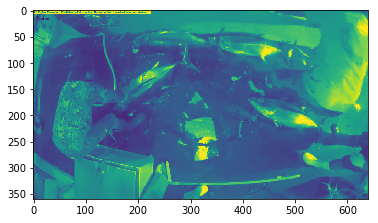

In [17]:
plt.imshow(x[0])

In [18]:
x[0].shape

(360, 640)

In [ ]:
model_bb = Sequential()
model_bb.add(ZeroPadding2D((1, 1), input_shape=(1, imgY, imgX)))
model_bb.add(Convolution2D(8, 3, 3, activation='relu', init='he_normal'))
model_bb.add(Dropout(0.2))
model_bb.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
model_bb.add(ZeroPadding2D((1, 1)))
model_bb.add(Convolution2D(16, 3, 3, activation='relu', init='he_normal'))
model_bb.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
model_bb.add(Dropout(0.2))

model_bb.add(Flatten())
model_bb.add(Dense(12, activation='relu',init='he_normal'))
model_bb.add(Dropout(0.4))
model_bb.add(Dense(12, activation='relu',init='he_normal'))
model_bb.add(Dropout(0.2))
model_bb.add(Dense(4))

model_bb.compile(optimizer=Adam(lr=0.001), loss='mse')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),]

model_bb.fit(X_train, bbox, batch_size=8, nb_epoch=3, validation_split=0.2, callbacks=callbacks)